# Section 5c: Job Failure Analysis

In [1]:
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from datetime import date, datetime, time, timedelta
import time, datetime, pytz
from datetime import datetime

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'libertine'

In [3]:
df = pd.read_parquet(path_job_dataset)
df

,id,submit_date,start_date,end_date,node,nodetypes,numnodes,numcores,state
0,1,2021-12-26 17:11:18,2021-12-26 23:06:31,2021-12-31 23:06:50,r13n5,normal,1,16,TIMEOUT
1,2,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r14n27,normal,1,16,TIMEOUT
2,3,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r15n12,normal,1,16,TIMEOUT
3,4,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r10n14,normal,1,16,TIMEOUT
4,5,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r10n30,normal,1,16,TIMEOUT
...,...,...,...,...,...,...,...,...,...
1596958,2323559,2022-11-01 13:55:57,2022-11-01 13:55:57,2022-11-01 13:58:54,r28n1,gpu_titanrtx_shared,1,6,CANCELLED
1596959,2323560,2022-11-01 13:56:12,2022-11-01 13:56:17,2022-11-01 13:56:24,r13n10,shared,1,6,FAILED
1596960,2323561,2022-11-01 13:56:45,2022-11-01 13:56:45,2022-11-01 13:58:12,r28n1,gpu_titanrtx_shared,1,6,FAILED
1596961,2323557,2022-11-01 13:54:21,2022-11-01 13:58:19,2022-11-01 13:59:01,r14n20,normal,1,16,COMPLETED


In [4]:
mark_ml_df(df)

# process column 'state'
df['state'] = df['state'].apply(lambda x: 'CANCELLED' if x is not None and x.startswith('CANCELLED') == True else x)

df["submit_day"] = df["submit_date"].dt.date
df["submit_hour_of_day"] = df["submit_date"].dt.hour
df["submit_day_of_week"] = df["submit_date"].apply(lambda x:x.weekday())  # dt.weekday

df['month_of_year'] = df["submit_date"].dt.month
df['week_of_year'] = df["submit_date"].apply(lambda x: x.strftime("%U"))
df['day_of_year'] = df["submit_date"].apply(lambda x: x.timetuple().tm_yday)
df["hour_of_year"] = df["submit_date"].apply(lambda x: int((x - datetime(x.year, 1, 1)).total_seconds() / 3600))
df["minute_of_year"] = df["submit_date"].apply(lambda x: int((x - datetime(x.year, 1, 1)).total_seconds() / 60))
df["second_of_year"] = df["submit_date"].apply(lambda x: int((x - datetime(x.year, 1, 1)).total_seconds()))

df["job_waiting_time"] = df["start_date"] - df["submit_date"]
df["job_waiting_time"] = df["job_waiting_time"].apply(lambda x:timedelta.total_seconds(x))
df["job_waiting_time"] = df["job_waiting_time"]/60/60 # hour

df["job_duration"] = df["end_date"] - df["start_date"]
df["job_duration"] = df["job_duration"].apply(lambda x:timedelta.total_seconds(x))
df["job_duration"] = df["job_duration"]/60/60 # hour

df["rack"] = df["node"].str.slice(0,3)

generic_df = df.loc[df["is_ml"] == 0]
ml_df = df.loc[df["is_ml"] == 1]
df

,id,submit_date,start_date,end_date,node,nodetypes,numnodes,numcores,state,split_nodes,...,submit_day_of_week,month_of_year,week_of_year,day_of_year,hour_of_year,minute_of_year,second_of_year,job_waiting_time,job_duration,rack
0,1,2021-12-26 17:11:18,2021-12-26 23:06:31,2021-12-31 23:06:50,r13n5,normal,1,16,TIMEOUT,{r13n5},...,6,12,52,360,8633,517991,31079478,5.920278,120.005278,r13
1,2,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r14n27,normal,1,16,TIMEOUT,{r14n27},...,6,12,52,360,8633,517991,31079478,5.923611,120.001944,r14
2,3,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r15n12,normal,1,16,TIMEOUT,{r15n12},...,6,12,52,360,8633,517991,31079478,5.923611,120.001944,r15
3,4,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r10n14,normal,1,16,TIMEOUT,{r10n14},...,6,12,52,360,8633,517991,31079478,5.923611,120.001944,r10
4,5,2021-12-26 17:11:18,2021-12-26 23:06:43,2021-12-31 23:06:50,r10n30,normal,1,16,TIMEOUT,{r10n30},...,6,12,52,360,8633,517991,31079478,5.923611,120.001944,r10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596958,2323559,2022-11-01 13:55:57,2022-11-01 13:55:57,2022-11-01 13:58:54,r28n1,gpu_titanrtx_shared,1,6,CANCELLED,{r28n1},...,1,11,44,305,7309,438595,26315757,0.000000,0.049167,r28
1596959,2323560,2022-11-01 13:56:12,2022-11-01 13:56:17,2022-11-01 13:56:24,r13n10,shared,1,6,FAILED,{r13n10},...,1,11,44,305,7309,438596,26315772,0.001389,0.001944,r13
1596960,2323561,2022-11-01 13:56:45,2022-11-01 13:56:45,2022-11-01 13:58:12,r28n1,gpu_titanrtx_shared,1,6,FAILED,{r28n1},...,1,11,44,305,7309,438596,26315805,0.000000,0.024167,r28
1596961,2323557,2022-11-01 13:54:21,2022-11-01 13:58:19,2022-11-01 13:59:01,r14n20,normal,1,16,COMPLETED,{r14n20},...,1,11,44,305,7309,438594,26315661,0.066111,0.011667,r14


In [5]:
ge_completed = generic_df[generic_df['state'] == 'COMPLETED']
ge_failed = generic_df[generic_df['state'] == 'FAILED']
ml_completed = ml_df[ml_df['state'] == 'COMPLETED']
ml_failed = ml_df[ml_df['state'] == 'FAILED']

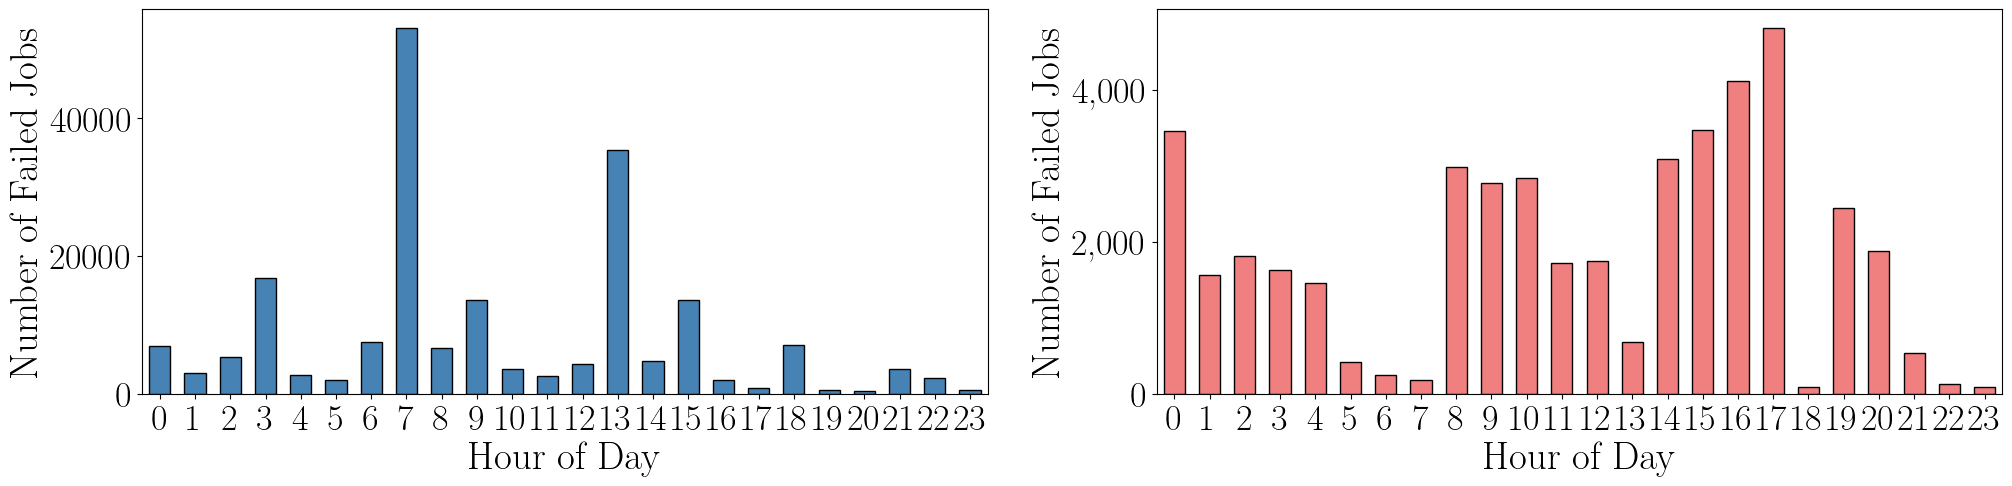

In [6]:
# fig-generic-ml-failures-day-of-hour
from matplotlib.pyplot import MultipleLocator

fig, axes = plt.subplots(figsize = (24, 5), nrows = 1, ncols = 2)
fig.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

x_vals = np.arange(ge_failed["submit_hour_of_day"].nunique())
y_vals = ge_failed["submit_hour_of_day"].value_counts(sort=False)
axes[0].bar(x_vals, y_vals, edgecolor='black', capsize=5, width = 0.6, color = 'steelblue')
axes[0].set_ylim(bottom=0, top=None)
axes[0].set_xlim(-0.5,23.5)
axes[0].set_xlabel("Hour of Day",  fontsize=28)
axes[0].set_ylabel("Number of Failed Jobs", fontsize=28)
axes[0].tick_params(axis='both', which='major', labelsize=26)
axes[0].tick_params(axis='both', which='minor', labelsize=26)
axes[0].xaxis.set_major_locator(MultipleLocator(1))


x_vals = np.arange(ml_failed["submit_hour_of_day"].nunique())
y_vals = ml_failed["submit_hour_of_day"].value_counts(sort=False)
axes[1].bar(x_vals, y_vals, edgecolor='black', capsize=5, width = 0.6, color = 'lightcoral')
axes[1].set_ylim(bottom=0, top=None)
axes[1].set_xlim(-0.5,23.5)
axes[1].set_xlabel("Hour of Day", fontsize=28)
axes[1].set_ylabel("Number of Failed Jobs", fontsize=28)
axes[1].tick_params(axis='both', which='major', labelsize=26)
axes[1].tick_params(axis='both', which='minor', labelsize=26)
axes[1].xaxis.set_major_locator(MultipleLocator(1))


#fig.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()
# fig.savefig('fig-generic-failures-week-and-day.pdf', bbox_inches = 'tight')

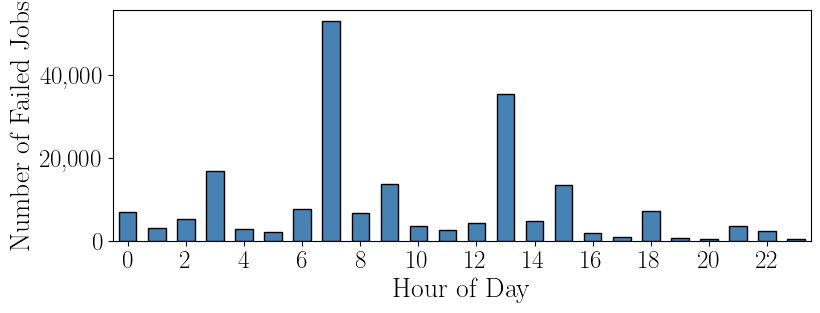

In [7]:
# fig-generic-ml-failures-day-of-hour
from matplotlib.pyplot import MultipleLocator

fig, axes = plt.subplots(figsize = (9, 3))
fig.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

x_vals = np.arange(ge_failed["submit_hour_of_day"].nunique())
y_vals = ge_failed["submit_hour_of_day"].value_counts(sort=False)
axes.bar(x_vals, y_vals, edgecolor='black', capsize=5, width = 0.6, color = 'steelblue')
axes.set_ylim(bottom=0, top=None)
axes.set_xlim(-0.5,23.5)
axes.set_xlabel("Hour of Day",  fontsize=20)
axes.set_ylabel("Number of Failed Jobs", fontsize=20)
axes.tick_params(axis='both', which='major', labelsize=18)
axes.tick_params(axis='both', which='minor', labelsize=18)
axes.set_xticks(np.arange(1, 22, step=2))
axes.xaxis.set_major_locator(MultipleLocator(2))


plt.show()
fig.savefig('plots/section_5/fig-generic-failures-hour-of-day.pdf', bbox_inches = 'tight')

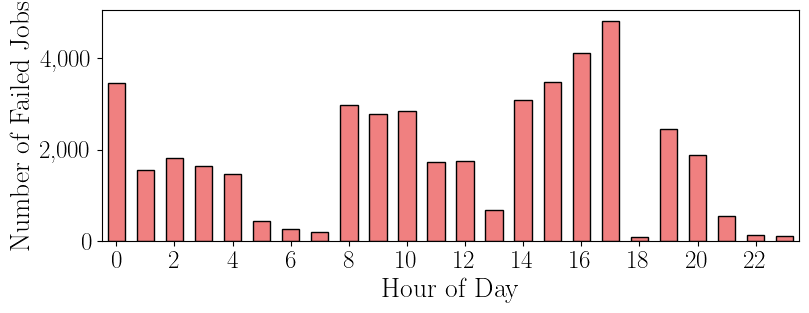

In [8]:
# fig-generic-ml-failures-day-of-hour
from matplotlib.pyplot import MultipleLocator

fig, axes = plt.subplots(figsize = (9, 3))
fig.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

x_vals = np.arange(ml_failed["submit_hour_of_day"].nunique())
y_vals = ml_failed["submit_hour_of_day"].value_counts(sort=False)
axes.bar(x_vals, y_vals, edgecolor='black', capsize=5, width = 0.6, color = 'lightcoral')
axes.set_ylim(bottom=0, top=None)
axes.set_xlim(-0.5,23.5)
axes.set_xlabel("Hour of Day",  fontsize=20)
axes.set_ylabel("Number of Failed Jobs", fontsize=20)
axes.tick_params(axis='both', which='major', labelsize=18)
axes.tick_params(axis='both', which='minor', labelsize=18)
axes.set_xticks(np.arange(1, 22, step=2))
axes.xaxis.set_major_locator(MultipleLocator(2))


plt.show()
fig.savefig('plots/section_5/fig-ml-failures-hour-of-day.pdf', bbox_inches = 'tight')